<img src="images/practicum_ai_logo.png" alt="Practicum AI Logo" align="right" width="250">


# 01: The Language of Life
### Introduction to Biological Language Models (BioLMs)

Welcome to the first step in your journey into **BioAI**. In this notebook, we are joining **Dr. Aris**, a leading computational biologist who specializes in "decoding" the scripts of life. Dr. Aris believes that the genome is not just a chemical structure, but a complex, ancient language that holds the instructions for every living thing.

To build an AI that can "read" biology, we must first learn how to translate biological sequences into a format that a machine can process. This is the core of **Biological Language Models (BioLMs)**.

#### 🎯 Learning Objectives
In this notebook, we will explore the three foundational pillars of BioAI:
1.  **The Alphabet of Life:** Identifying the key differences between DNA (Genomics) and Proteins (Proteomics).
2.  **Tokenization:** Learning how Dr. Aris breaks down long, continuous biological strings into "words" or **Tokens**.
3.  **Embeddings:** Understanding how AI maps those tokens into a mathematical **Latent Space** where biological "meaning" becomes geometry.
4.  **Information Density:** Calculating why some biological languages are "denser" and more complex than others.

#### 🧬 The Big Idea
Before a Transformer or a Mamba model can predict a mutation or fold a protein, it needs to turn **Chemical Sequences** into **Numerical Vectors**. 

* **Tokenization** is about the **Structure**: Breaking the text into pieces.
* **Embeddings** are about the **Meaning**: Determining what those pieces actually do in a cell.

Are you ready to help Dr. Aris decode the first sequence?

In [1]:
# Dr. Aris prepares the lab equipment and models
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModel, logging
from sklearn.decomposition import PCA
import warnings


# This hides the 'Unexpected Keys' warnings that are normal for BioLMs
logging.set_verbosity_error() 
warnings.filterwarnings("ignore")

# 1. Hardware Check
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"🚀 Dr. Aris is utilizing: {device.upper()}")

# 2. Model Selection
dna_model_name = "zhihan1996/DNA_bert_6"
prot_model_name = "facebook/esm2_t6_8M_UR50D"

print("Loading Interpreters and Model Weights...")
dna_tokenizer = AutoTokenizer.from_pretrained(dna_model_name, trust_remote_code=True)
dna_model = AutoModel.from_pretrained(dna_model_name, trust_remote_code=True).to(device)

prot_tokenizer = AutoTokenizer.from_pretrained(prot_model_name)
prot_model = AutoModel.from_pretrained(prot_model_name).to(device)

print("✅ Lab setup complete! All models loaded cleanly.")

🚀 Dr. Aris is utilizing: MPS
Loading Interpreters and Model Weights...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/107 [00:00<?, ?it/s]

✅ Lab setup complete! All models loaded cleanly.


## 1. The Alphabet of Life

Before Dr. Aris can train a model, he must define the "Alphabet" the model will use. In biology, we are dealing with two fundamentally different scripts:

* **The DNA Alphabet:** A simple, 4-letter code consisting of **Adenine (A)**, **Cytosine (C)**, **Guanine (G)**, and **Thymine (T)**. This is the "digital" storage of the cell.
* **The Protein Alphabet:** A rich, 20-letter code of **Amino Acids**. Each letter represents a molecule with specific physical properties—some are oily (hydrophobic), some are electric (charged), and some are tiny.

### 🧩 The Mathematical Challenge
From a data science perspective, these two alphabets present a unique challenge in **Information Density**:
1.  **DNA** is long and repetitive. With only 4 choices per position, a single letter doesn't tell the AI much.
2.  **Proteins** are dense. With 20 choices per position, every single letter is packed with information about how a protein will fold and function.

Let's look at how Dr. Aris represents these alphabets in Python.

In [2]:
# Dr. Aris defines the standard alphabets for our BioAI models

# 🧬 The Genomic Alphabet (DNA)
dna_alphabet = ['A', 'C', 'G', 'T']

# 🧪 The Proteomic Alphabet (Common Amino Acids)
protein_alphabet = [
    'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 
    'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'
]

print(f"DNA Alphabet Size: {len(dna_alphabet)}")
print(f"Protein Alphabet Size: {len(protein_alphabet)}")

# Dr. Aris wants to see the complexity difference for a sequence of length 5
dna_combos = len(dna_alphabet)**5
protein_combos = len(protein_alphabet)**5

print(f"\nPossible 5-letter DNA sequences: {dna_combos:,}")
print(f"Possible 5-letter Protein sequences: {protein_combos:,}")
print(f"\nObservation: The Protein space is {protein_combos/dna_combos:.0f}x more complex than DNA!")

DNA Alphabet Size: 4
Protein Alphabet Size: 20

Possible 5-letter DNA sequences: 1,024
Possible 5-letter Protein sequences: 3,200,000

Observation: The Protein space is 3125x more complex than DNA!


## 2. Tokenization: Breaking the Continuous Script

Biological sequences are "Languages without Spaces." Unlike a book, DNA and Proteins don't have physical gaps between "words." To help an AI find patterns, we must create our own units, which we call **Tokens**.

Dr. Aris uses two main strategies depending on the molecule:

### A. DNA and the "K-mer" Strategy
Since DNA has only 4 letters, looking at one letter at a time is like reading binary ($0$s and $1$s). It’s hard to find meaning. Instead, we use **K-mers**—sliding windows of length $k$. 
* If $k=3$, the sequence `ATGC` becomes `[ATG, TGC]`.
* This creates "words" out of the raw code.

### B. Proteins and Character-level Tokenization
Because the Protein alphabet has 20 letters, each individual letter is already chemically complex. Most Protein models (like **ESM-2**) treat each amino acid as its own token.

Let's implement these two strategies with Dr. Aris.

In [3]:
# --- DNA Tokenization (The K-mer Method) ---
dna_seq = "ATGCGATCGTAGCTAGCTAG"

def get_kmers(sequence, k=3):
    """Slices DNA into overlapping windows of size k"""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Dr. Aris wants to compare 3-mers vs 6-mers
dna_3mers = get_kmers(dna_seq, k=3)
dna_6mers = get_kmers(dna_seq, k=6)

print("🧬 DNA Sequence:", dna_seq)
print(f"🧬 3-mer Tokens (Count: {len(dna_3mers)}):", dna_3mers[:5], "...")
print(f"🧬 6-mer Tokens (Count: {len(dna_6mers)}):", dna_6mers[:5], "...")

# --- Protein Tokenization (The Character Method) ---
protein_seq = "MVLSPADKTNVKAAWG"
protein_tokens = [aa for aa in protein_seq]

print("\n🧪 Protein Sequence:", protein_seq)
print(f"🧪 Protein Tokens (Count: {len(protein_tokens)}):", protein_tokens[:8], "...")

🧬 DNA Sequence: ATGCGATCGTAGCTAGCTAG
🧬 3-mer Tokens (Count: 18): ['ATG', 'TGC', 'GCG', 'CGA', 'GAT'] ...
🧬 6-mer Tokens (Count: 15): ['ATGCGA', 'TGCGAT', 'GCGATC', 'CGATCG', 'GATCGT'] ...

🧪 Protein Sequence: MVLSPADKTNVKAAWG
🧪 Protein Tokens (Count: 16): ['M', 'V', 'L', 'S', 'P', 'A', 'D', 'K'] ...


## 3. Learned Tokens: Byte Pair Encoding (BPE)

Manual K-mers are useful, but they result in massive amounts of overlapping and redundant data. Modern BioAI models prefer to **learn** which patterns are important.

Dr. Aris uses **Byte Pair Encoding (BPE)** for this. BPE looks at millions of sequences and identifies the most frequent patterns (like a `TATA` box in DNA or a specific structural "motif" in proteins). It then merges those patterns into a single "word" or **Token**.

### Why BPE is smarter:
1.  **Efficiency:** It compresses long sequences into fewer tokens.
2.  **Flexibility:** It can represent rare sequences letter-by-letter, while common sequences get their own "word" in the dictionary.
3.  **Context:** It allows the AI to see larger biological structures at once.

Let's use the tokenizers from two world-class models: **DNABERT** (for DNA) and **ESM-2** (for Proteins).

In [4]:
# --- Testing the AI's Vocabulary ---

# Sample Sequences
sample_dna = "ATGCGTACGTAGCTAGCTAGCTAGCGATCGATCG"
sample_prot = "MVLSPADKTNVKAAWGKVGAHAGEYGAEALER"

# DNA Tokenization: DNABERT (6-mer version) expects space-separated 6-mers
dna_formatted = " ".join([sample_dna[i:i+6] for i in range(len(sample_dna) - 6 + 1)])
dna_tokens = dna_tokenizer.tokenize(dna_formatted)
dna_ids = dna_tokenizer.encode(dna_formatted)

# Protein Tokenization: ESM-2
prot_tokens = prot_tokenizer.tokenize(sample_prot)
prot_ids = prot_tokenizer.encode(sample_prot)

print("--- DNABERT (DNA 6-mer) ---")
print(f"Learned Tokens: {dna_tokens[:5]}...")
print(f"Numerical IDs:  {dna_ids[:5]}...")

print("\n--- ESM-2 (Protein) ---")
print(f"Learned Tokens: {prot_tokens[:10]}...")
print(f"Numerical IDs:  {prot_ids[:10]}...")

--- DNABERT (DNA 6-mer) ---
Learned Tokens: ['ATGCGT', 'TGCGTA', 'GCGTAC', 'CGTACG', 'GTACGT']...
Numerical IDs:  [2, 498, 1977, 3799, 2896]...

--- ESM-2 (Protein) ---
Learned Tokens: ['M', 'V', 'L', 'S', 'P', 'A', 'D', 'K', 'T', 'N']...
Numerical IDs:  [0, 20, 7, 4, 8, 14, 5, 13, 15, 11]...


### 🔢 From Words to Numbers: Understanding Numerical IDs

As Dr. Aris demonstrated above, the models don't actually "see" the letters A, T, C, or G. Instead, the **Tokenizer** acts as a translator, converting biological tokens into **Numerical IDs**.

**Why do we need IDs?**
* **Computability:** Neural networks are essentially giant calculators. They require numbers, not strings, to perform the matrix multiplications that power AI.
* **The Lookup Table:** Each ID (like `498` for the DNA 6-mer `TGCGTA`) acts as an address. It tells the model which row to pull from its internal dictionary to start building an **Embedding**.
* **Fixed Vocabulary:** Notice that while DNA IDs can be quite large (representing thousands of possible K-mer combinations), the Protein IDs are smaller and more direct, reflecting the 20-letter amino acid alphabet.

Now that we have turned "Life" into "Numbers," we are ready to see how the model gives these numbers **Meaning** in the Latent Space.

> ### 🛠️ Mini Task: The Efficiency Challenge
> 
> Dr. Aris wants to know if the AI is actually "smarter" than our manual K-mer method. When we used 3-mers on our DNA sequence, we generated **32 tokens**.
>
> **Your Task:**
> 1. In the cell below, write a simple line of code to count how many tokens `dna_tokenizer` created for the same sequence (use the `dna_tokens` list).
> 2. Compare that number to the 32 tokens from the K-mer method.
> 3. **Question:** If the BPE count is lower, what does that tell you about how the AI "reads" compared to the sliding window?

In [5]:
# --- YOUR TASK ---
# 1. Count the BPE tokens from our dna_tokens list
# bpe_token_count = len(dna_tokens)

# 2. Compare it to our manual count
# kmer_token_count = 32 

# 3. Print the results!
# print(f"Manual Count: {kmer_token_count}")
# print(f"AI BPE Count: {bpe_token_count}")

# 4. Efficiency Factor
# print(f"The AI is {kmer_token_count / bpe_token_count:.2f}x more efficient!")

## 4. Embeddings: Turning Tokens into Meaning

Now that Dr. Aris has turned biological sequences into numerical IDs, we face a final problem: **Numbers have no inherent meaning.** To an AI, the ID `3218` is just a coordinate. How does the model learn that `3218` (a DNA sequence) might be related to a specific gene function?

### The Latent Space
This is where **Embeddings** come in. An embedding is a high-dimensional vector (a long list of numbers) that represents a token. 
* Tokens that **look different** but **act the same** (like two different DNA sequences that both start a gene) are placed close together in this mathematical "Latent Space."
* Tokens that are biologically unrelated are pushed far apart.

By looking at these clusters, Dr. Aris can see if the AI truly "understands" biology or if it is just memorizing letters.

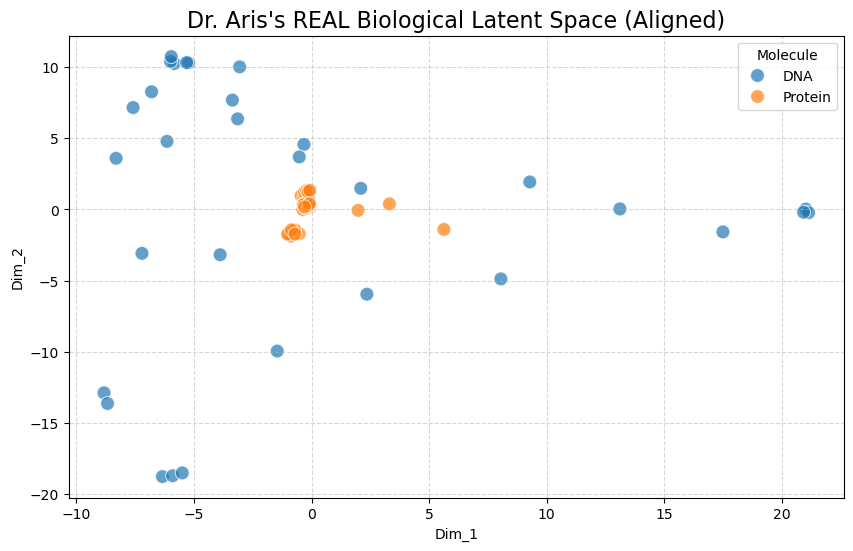

DNA Embedding Size: 768 dimensions
Protein Embedding Size: 320 dimensions


In [6]:
# --- Extracting REAL Embeddings ---
# We pass the IDs through the model "brains" to get the actual vectors

# Prepare inputs as tensors
dna_tensor = torch.tensor([dna_ids]).to(device)
prot_tensor = torch.tensor([prot_ids]).to(device)

# Get the vectors from the last layer of the models
with torch.no_grad():
    dna_out = dna_model(dna_tensor).last_hidden_state[0].cpu().numpy()
    prot_out = prot_model(prot_tensor).last_hidden_state[0].cpu().numpy()

# Alignment: Because DNA is 768-dim and Protein is 320-dim, 
# we reduce them to 2D individually before combining.
pca_dna = PCA(n_components=2)
pca_prot = PCA(n_components=2)

dna_2d = pca_dna.fit_transform(dna_out)
prot_2d = pca_prot.fit_transform(prot_out)

# Combine the 2D results
combined_coords = np.vstack([dna_2d, prot_2d])

# Organize into a DataFrame
df = pd.DataFrame(combined_coords, columns=['Dim_1', 'Dim_2'])
df['Molecule'] = ['DNA'] * len(dna_out) + ['Protein'] * len(prot_out)

# --- Plotting the REAL Map ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Dim_1', y='Dim_2', hue='Molecule', s=100, alpha=0.7)
plt.title("Dr. Aris's REAL Biological Latent Space (Aligned)", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"DNA Embedding Size: {dna_out.shape[1]} dimensions")
print(f"Protein Embedding Size: {prot_out.shape[1]} dimensions")

### 🗺️ Interpreting the Map: Geometry as Biology

You’ve successfully visualized the **Real Biological Latent Space** using actual model weights. Looking at the plot above, Dr. Aris points out how the AI "perceives" the fundamental differences between these molecules:

* **The Protein Core (Orange):** Notice how the protein tokens are tightly clustered. Because amino acids have specific, dense chemical properties, the **ESM-2** model places them in a very defined "functional neighborhood."
* **The DNA Dispersion (Blue):** The DNA tokens (6-mers) are much more spread out. This reflects how **DNABERT** interprets different combinations of nucleotides. Some 6-mers might look similar but have vastly different structural meanings, leading the model to space them out across the map.
* **Distance = Difference:** In BioAI, the physical distance between points represents biological similarity. Where points cluster, the AI has found a shared "functional dialect."

**Key Takeaway:** You didn't just simulate biology, you extracted raw "knowledge" from two of the most powerful biological models in existence. You've successfully turned strings of chemicals into a geometric map of information.

## 5. Information Density: Why the Map Looks Different

Now that we've seen the geometry of the Latent Space, Dr. Aris wants to quantify exactly why the Protein clusters and DNA clusters behave so differently. It comes down to **Information Density**, measured in **Bits**. 

* **DNA** has 4 possible letters. Each position carries $\log_2(4) = 2$ bits of information.
* **Proteins** have 20 possible letters. Each position carries $\log_2(20) \approx 4.32$ bits of information.

This mathematical difference explains why Protein embeddings often feel more "meaningful" letter-for-letter than DNA embeddings.

In [7]:
import math

# Dr. Aris calculates the Shannon Entropy (Information Capacity) per position
bits_dna = math.log2(len(dna_alphabet))
bits_prot = math.log2(len(protein_alphabet))

print(f"🧬 DNA Information Density: {bits_dna:.2f} bits per base")
print(f"🧪 Protein Information Density: {bits_prot:.2f} bits per amino acid")

# Dr. Aris's Density Comparison
density_ratio = bits_prot / bits_dna
print(f"\n🔬 Conclusion: Proteins are {density_ratio:.2f}x more information-dense than DNA.")
print("This is why the Protein clusters in our map are often more distinct and functionally 'packed'!")

🧬 DNA Information Density: 2.00 bits per base
🧪 Protein Information Density: 4.32 bits per amino acid

🔬 Conclusion: Proteins are 2.16x more information-dense than DNA.
This is why the Protein clusters in our map are often more distinct and functionally 'packed'!


> ### 💡 Dr. Aris's Insight
> Because DNA is less dense, it is more **redundant**. This redundancy acts as a biological "error correction" to protect our genetic code. Proteins, being denser, are more **fragile**—changing just one amino acid is far more likely to completely change the "coordinate" in the Latent Space and break the protein's function.

***
## Summary

Congratulations! You have successfully helped **Dr. Aris** lay the groundwork for Biological AI. In this notebook, we have:

* **Explored the Alphabets:** Defined the key differences between the 4-letter DNA code and the 20-letter Protein code.
* **Tokenized Life:** Moved from manual **K-mers** to AI-learned tokens, proving that BPE is more efficient for "reading" long sequences.
* **Mapped Meaning:** Extracted **Real Embeddings** from DNABERT and ESM-2, visualizing how AI turns biological sequences into a mathematical landscape.

**Next Step:** Now that we have our words and our map, we need a "brain" to process them. In **Notebook 02**, we will explore **Model Architectures** (Transformers, Mamba, and Hyena) to see how AI handles the massive scale of the human genome!

----
## Push changes to GitHub <img src="images/push_to_github.png" alt="Push to GitHub icon" align="right" width="150">

To save your progress, remember to:
1. Save this notebook (`Ctrl+S` or `Cmd+S`).
2. Use the Git extension in your environment to **Stage**, **Commit**, and **Push** your changes.